# Stereo Depth Estimation
This notebook demonstrates stereo vision-based depth estimation using feature matching, fundamental and essential matrix computation, rectification, and disparity mapping.

### **Overview of Steps:**
1. Feature Matching using ORB
2. Estimation of the Fundamental Matrix
3. Computing the Essential Matrix
4. Decomposing the Essential Matrix to get Rotation & Translation
5. Rectification of Stereo Images
6. Generating Disparity & Depth Maps

The images used are from a stereo dataset, and camera calibration parameters are loaded from a text file.


## **Mounting Google Drive**
We mount Google Drive to access stored datasets for stereo depth estimation.


In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
path_to_folder = "ENPM673/"
%cd /content/drive/My\ Drive/{path_to_folder}

Mounted at /content/drive/
/content/drive/My Drive/ENPM673


## **Feature Matching with ORB**
Feature matching is used to identify keypoints and corresponding features in two stereo images.
- ORB (Oriented FAST and Rotated BRIEF) is used for feature detection.
- Brute-Force Matcher is applied to find feature correspondences.


## **Fundamental Matrix Estimation**
The fundamental matrix **F** defines the geometric relationship between two images.
- **RANSAC (Random Sample Consensus)** is used to find robust matches.
- It removes outliers and ensures correct epipolar geometry constraints.


## **Essential Matrix Computation & Camera Pose Estimation**
The essential matrix **E** is derived from the fundamental matrix **F**:
\[
E = K^T F K
\]
where **K** is the camera calibration matrix.

- The **Essential Matrix** encodes the relative pose (rotation & translation) of the stereo cameras.
- The **recoverPose** function extracts the camera pose from **E**.


## **Stereo Rectification**
Stereo rectification aligns two images to the same horizontal plane.
- It helps ensure epipolar lines are parallel.
- Homography matrices **H1, H2** transform images for alignment.


## **Depth Estimation from Disparity**
Disparity refers to the pixel difference between corresponding points in two images. The depth is computed using:

\[
Depth = \frac{Baseline \times Focal Length}{Disparity}
\]

- **Baseline**: Distance between the stereo cameras.
- **Focal Length**: Intrinsic parameter of the camera.
- **Disparity**: Pixel shift between left and right images.

Higher disparity means closer objects, and lower disparity means farther objects.


In [12]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import os

def load_calibration(calib_file):
    with open(calib_file, 'r') as f:
        lines = f.readlines()
        # Parse calibration parameters
        params = {}
        for line in lines:
            key, values = line.strip().split('=')
            if key == 'cam0' or key == 'cam1':
                # Extract camera calibration matrix
                values = values.strip().replace('[', '').replace(']', '').split(';')
                values = [[float(v.strip()) for v in row.split()] for row in values]
                params[key] = np.array(values, dtype=np.float32)

            elif key == 'baseline':
                params[key] = float(line.split('=')[1])
            else:
                params[key] = float(values)
        return params

# Step 1: Feature Matching
def feature_matching(img1, img2):
    orb = cv2.ORB_create()
    keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(img2,None)
    return keypoints1, keypoints2, descriptors1, descriptors2

# Step 2: Estimate Fundamental Matrix
def estimate_fundamental_matrix(keypoints1, keypoints2, descriptors1, descriptors2, ransac_reproj_threshold=3.0):
    # Create BFMatcher object
    matcher = cv2.BFMatcher(cv2.NORM_L2)

    # Match descriptors
    matches = matcher.knnMatch(descriptors1, descriptors2, k=2)

    # Apply ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # Extract matched keypoints
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    F, mask = cv2.findFundamentalMat(src_pts, dst_pts, cv2.FM_RANSAC)

    points1 = src_pts[mask.ravel() == 1]
    points2 = dst_pts[mask.ravel() == 1]

    return F, mask, points1, points2

def compute_essential_matrix(F, fx, fy):
    E = np.dot(fy.T, np.dot(F, fx))

    return E

# Step 4: Decompose Essential Matrix
def decompose_essential_matrix(E, points1, points2):
    retval, R, t, mask = cv2.recoverPose(E, points1, points2, focal=1746.24, pp=(14.88, 534.11))
    return R, t

def rectify_images(img1, img2, F, mask, keypoints1, keypoints2):
    # Extract (x, y) coordinates from keypoints
    keypoints1 = np.array([kp.pt for kp in keypoints1])
    keypoints2 = np.array([kp.pt for kp in keypoints2])

    # Convert keypoints to the required data type
    keypoints1 = keypoints1.reshape(-1, 1, 2).astype(np.float32)
    keypoints2 = keypoints2.reshape(-1, 1, 2).astype(np.float32)

    # Find epilines corresponding to points in the first image and drawing its lines on the second image
    lines1 = cv2.computeCorrespondEpilines(keypoints1, 1, F)
    lines1 = lines1.reshape(-1, 3)
    img1_epilines = cv2.computeCorrespondEpilines(keypoints1, 2, F)
    img1_epilines = img1_epilines.reshape(-1, 3)

    # Draw epilines on img2
    img2_epilines = cv2.computeCorrespondEpilines(keypoints2, 1, F)
    img2_epilines = img2_epilines.reshape(-1, 3)
    img2_epilines = img2_epilines.astype(np.float32)
    img2_epilines[:, [0, 1]] = img2_epilines[:, [1, 0]]
    img2_epilines[:, [0, 1]] *= -1
    img2_epilines[:, [1, 2]] = img2_epilines[:, [2, 1]]

    # Draw epipolar lines and keypoints on img1 and img2
    for r, pt1, pt2 in zip(lines1, keypoints1, keypoints2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [img2.shape[1], -(r[2] + r[0] * img2.shape[1]) / r[1]])
        img1 = cv2.line(img1, (x0, y0), (x1, y1), color, 1)
        img1 = cv2.circle(img1, (int(pt1[0][0]), int(pt1[0][1])), 5, color, -1)
        img2 = cv2.circle(img2, (int(pt2[0][0]), int(pt2[0][1])), 5, color, -1)

    return img1, img2

def lines_rect(img1src, img2src, lines, pts1src, pts2src):

    img1color = cv2.cvtColor(img1src, cv2.COLOR_GRAY2BGR)
    img2color = cv2.cvtColor(img2src, cv2.COLOR_GRAY2BGR)

    np.random.seed(0)

    r, c = img1src.shape

    for r, pt1, pt2 in zip(lines, pts1src, pts2src):

        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, pt1[1]])
        x1, y1 = map(int, [c, pt1[1]])
        img1color = cv2.line(img1color, (x0, y0), (x1, y1), color, 3)
        img1color = cv2.circle((img1color), (int(pt1[0]), int(pt1[1])), 7, (0, 0, 200), -1)

        x0, y0 = map(int, [0, pt2[1]])
        x1, y1 = map(int, [c, pt2[1]])
        img2color = cv2.line((img2color), (x0, y0), (x1, y1), (color), 3)
        img2color = cv2.circle(img2color, (int(pt2[0]), int(pt2[1])), 7, (0, 0, 200), -1)

    return img1color, img2color


def rectification_pipeline(img1, img2, F, mask, keypoints1, keypoints2):

    img1 = cv2.cvtColor(cv2.imread('im0.png'), cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(cv2.imread('im1.png'), cv2.COLOR_BGR2GRAY)

    # Print homography matrices (H1 and H2) for rectification
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    _, H1,H2 = cv2.stereoRectifyUncalibrated(keypoints1, keypoints2, F, imgSize=(w1, h1))

    print("Homography Matrix H1:")
    print(H1)
    print("\nHomography Matrix H2:")
    print(H2)

    img1_rect = cv2.warpPerspective(img1, H1, (w1, h1))
    img2_rect = cv2.warpPerspective(img2, H2, (w2, h2))

    points1_rect = cv2.perspectiveTransform(keypoints1.reshape(-1, 1, 2), H1).reshape(-1,2)
    points2_rect = cv2.perspectiveTransform(keypoints2.reshape(-1, 1, 2), H2).reshape(-1,2)

    lines1 = cv2.computeCorrespondEpilines(
        points2_rect.reshape(-1, 1, 2), 2, F)
    lines1 = lines1.reshape(-1, 3)
    img_1, img_2 = lines_rect(img1_rect, img2_rect, lines1, points1_rect, points2_rect)

    lines2 = cv2.computeCorrespondEpilines(
        points1_rect.reshape(-1, 1, 2), 1, F)
    lines2 = lines2.reshape(-1, 3)
    img_3, img_4 = lines_rect(img2_rect, img1_rect, lines2, points2_rect, points1_rect)

    result_1 = np.concatenate((img_3, img_1), axis=1)
    horizontal_concat = cv2.hconcat([img1_rect, img2_rect])



    plt.figure(figsize=(100, 80))
    plt.title("Matched Features")
    plt.imshow(result_1)
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(100, 80))
    plt.subplot(1, 2, 1)
    plt.title("Image 1 Rectified")
    plt.imshow(cv2.cvtColor(img1_rect, cv2.COLOR_RGB2BGR))
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title("Image 2 Rectified")
    plt.imshow(cv2.cvtColor(img2_rect, cv2.COLOR_RGB2BGR))
    plt.axis('off')
    plt.show()



    return img1_rect, img2_rect

def disparityToDepth(baseline, f, img, disparity_norm):
    depthmap = np.zeros((img.shape[0], img.shape[1]))
    deptharray = np.zeros((img.shape[0], img.shape[1]))

    for i in range(depthmap.shape[0]):
        for j in range(depthmap.shape[1]):
            depthmap[i][j] = 1/img[i][j]
            deptharray[i][j] = baseline*f/img[i][j]


    # Create a figure with three subplots side by side
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # Adjust width to fit plots horizontally

    # Disparity Map (Grayscale)
    im1 = axes[0].imshow(disparity_norm, cmap='gray')
    axes[0].set_title('Disparity Map')
    fig.colorbar(im1, ax=axes[0])
    axes[0].axis("off")

    # Depth Map (Jet colormap)
    im2 = axes[1].imshow(depthmap, cmap='jet')
    axes[1].set_title('Depth Map')
    fig.colorbar(im2, ax=axes[1])
    axes[1].axis("off")

    # Grayscale Depth Map
    im3 = axes[2].imshow(depthmap, cmap='gray')
    axes[2].set_title('Grayscale Depth Map')
    fig.colorbar(im3, ax=axes[2])
    axes[2].axis("off")

    # Adjust layout
    plt.tight_layout()
    plt.show()




## **Stereo Vision Pipeline**
This function runs the entire pipeline:
1. Load camera calibration parameters
2. Detect and match features
3. Estimate fundamental & essential matrices
4. Compute rotation & translation (camera pose)
5. Perform image rectification
6. Compute disparity and generate a depth map


In [13]:
# Main function
def pipeline(params, img1, img2):

    # Step 1: Feature Matching
    keypoints1, keypoints2, descriptors1, descriptors2 = feature_matching(img1, img2)

    # Step 2: Estimate Fundamental Matrix
    F, mask, points1, points2 = estimate_fundamental_matrix(keypoints1, keypoints2, descriptors1, descriptors2)

    # Step 3: Compute Essential Matrix
    E = compute_essential_matrix(F, params['cam0'], params['cam1'])

    # Step 4: Decompose Essential Matrix
    R, T = decompose_essential_matrix(E, points1, points2)

    print("Rotation Matrix:")
    print(R)
    print("\nTranslation Vector:")
    print(T)

    image1_rect, image2_rect = rectification_pipeline(img1, img2, F, mask, points1, points2)

    fx = params['cam0'][0, 0]
    fy = params['cam1'][1, 1]
    focal_length = (fx + fy) / 2

    stereo = cv2.StereoBM_create(numDisparities=64, blockSize=13)


    disparity = stereo.compute(image1_rect, image2_rect)

    disparity_norm = cv2.normalize(disparity, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)


    disparityToDepth(params['baseline'],focal_length, disparity, disparity_norm)

def prepipe(path_to_folder):
    # Load calibration parameters
    params = load_calibration(path_to_folder+'calib.txt')

    # Load images from dataset
    img1 = cv2.imread(path_to_folder+'im0.png')
    img2 = cv2.imread(path_to_folder+'im1.png')

    # pipeline for stereo camera
    pipeline(params, img1, img2)


## **Testing on Different Datasets**
We test stereo depth estimation on three different datasets:
- **Storage Room**
- **Class Room**
- **Trap Room**

Each function loads the respective dataset and runs the pipeline.


In [14]:
def storage_room():
    path_to_folder = "/content/drive/MyDrive/ENPM673/project3/project3_2/problem2_dataset/storageroom/"
    os.chdir(path_to_folder)
    print(os.getcwd())
    prepipe(path_to_folder)

def class_room():
    path_to_folder = "/content/drive/MyDrive/ENPM673/project3/project3_2/problem2_dataset/classroom/"
    os.chdir(path_to_folder)
    print(os.getcwd())
    prepipe(path_to_folder)

def trap_room():
    path_to_folder = "/content/drive/MyDrive/ENPM673/project3/project3_2/problem2_dataset/traproom/"
    os.chdir(path_to_folder)
    print(os.getcwd())
    prepipe(path_to_folder)


/content/drive/MyDrive/ENPM673/project3/project3_2/problem2_dataset/storageroom
Rotation Matrix:
[[ 0.99981241  0.00278098 -0.0191682 ]
 [-0.00281129  0.99999484 -0.00155452]
 [ 0.01916377  0.00160812  0.99981506]]

Translation Vector:
[[-0.00451118]
 [ 0.1790947 ]
 [-0.9838215 ]]
Homography Matrix H1:
[[-3.02265695e-01 -6.45644110e-01  4.63771846e+02]
 [ 4.21178947e-02 -3.05860600e-01  3.37236636e+01]
 [-2.02747882e-04 -4.36161740e-04  2.70732252e-01]]

Homography Matrix H2:
[[ 1.58505280e+00  3.40380287e+00 -2.39970424e+03]
 [-2.52392610e-01  1.82686099e+00 -2.04208028e+02]
 [ 1.21136308e-03  2.60132729e-03 -1.56762529e+00]]


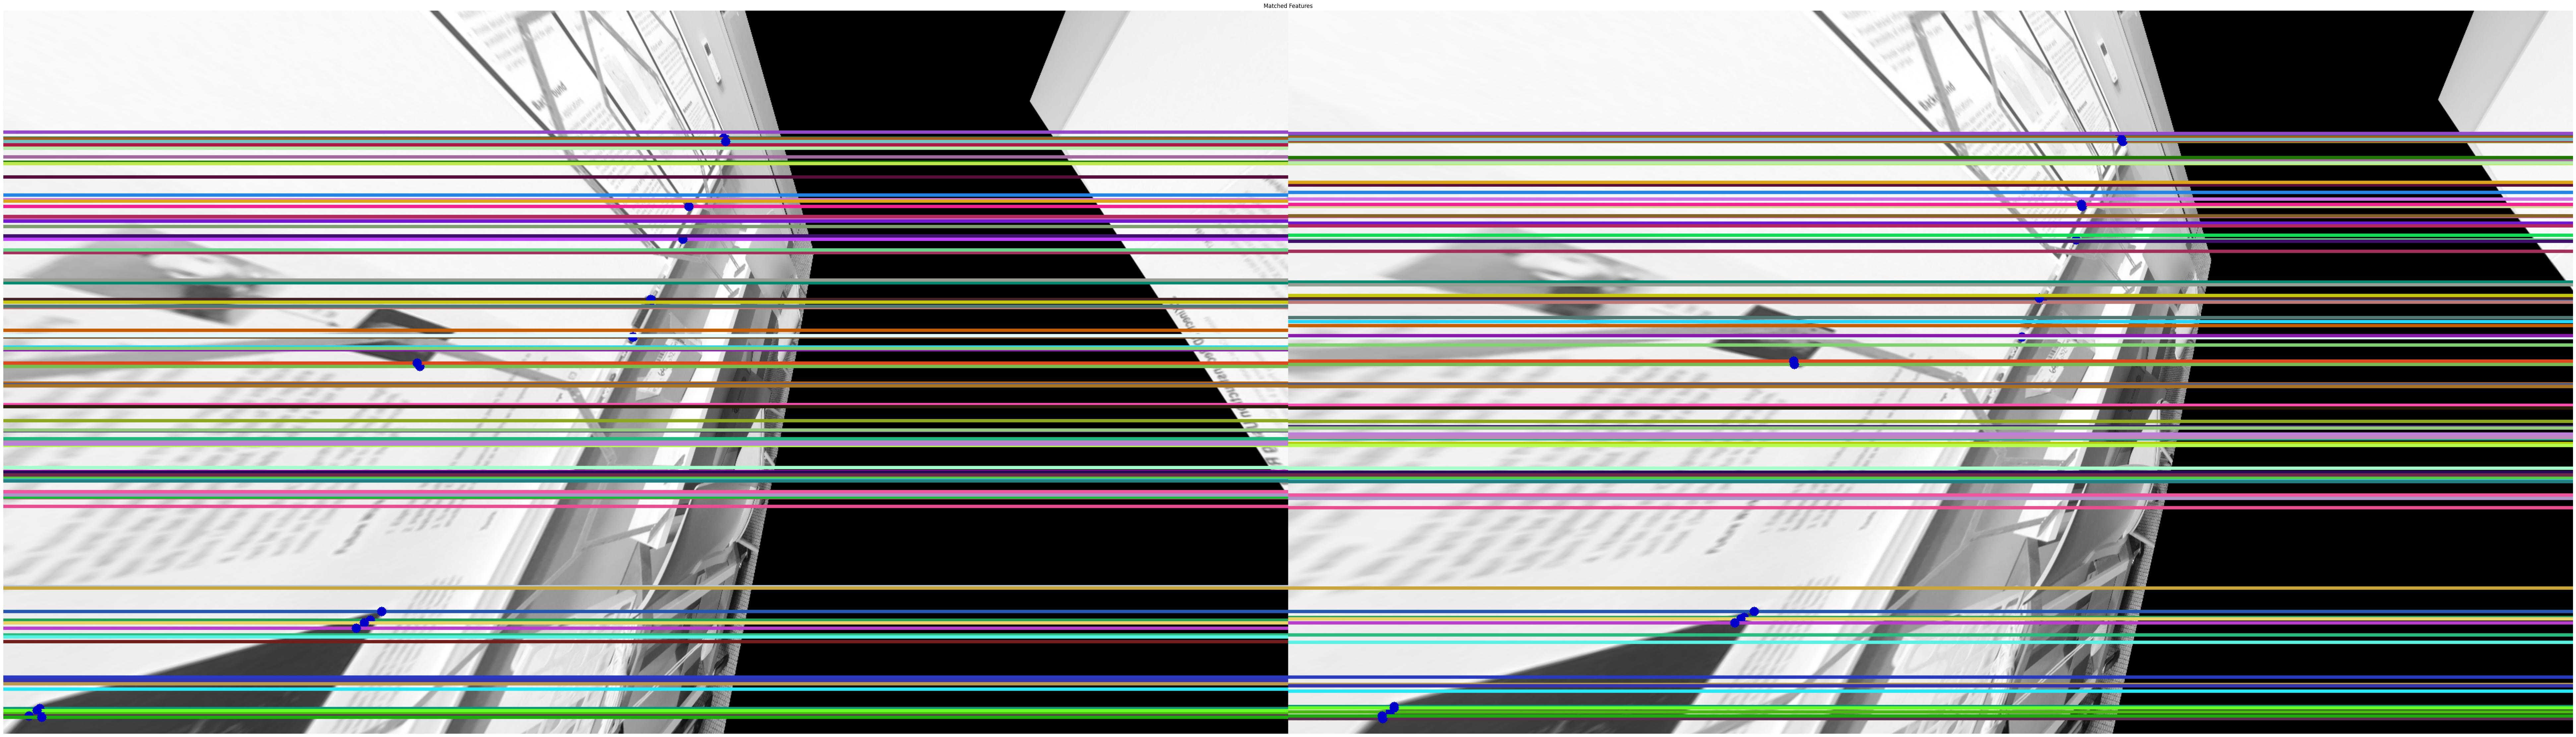

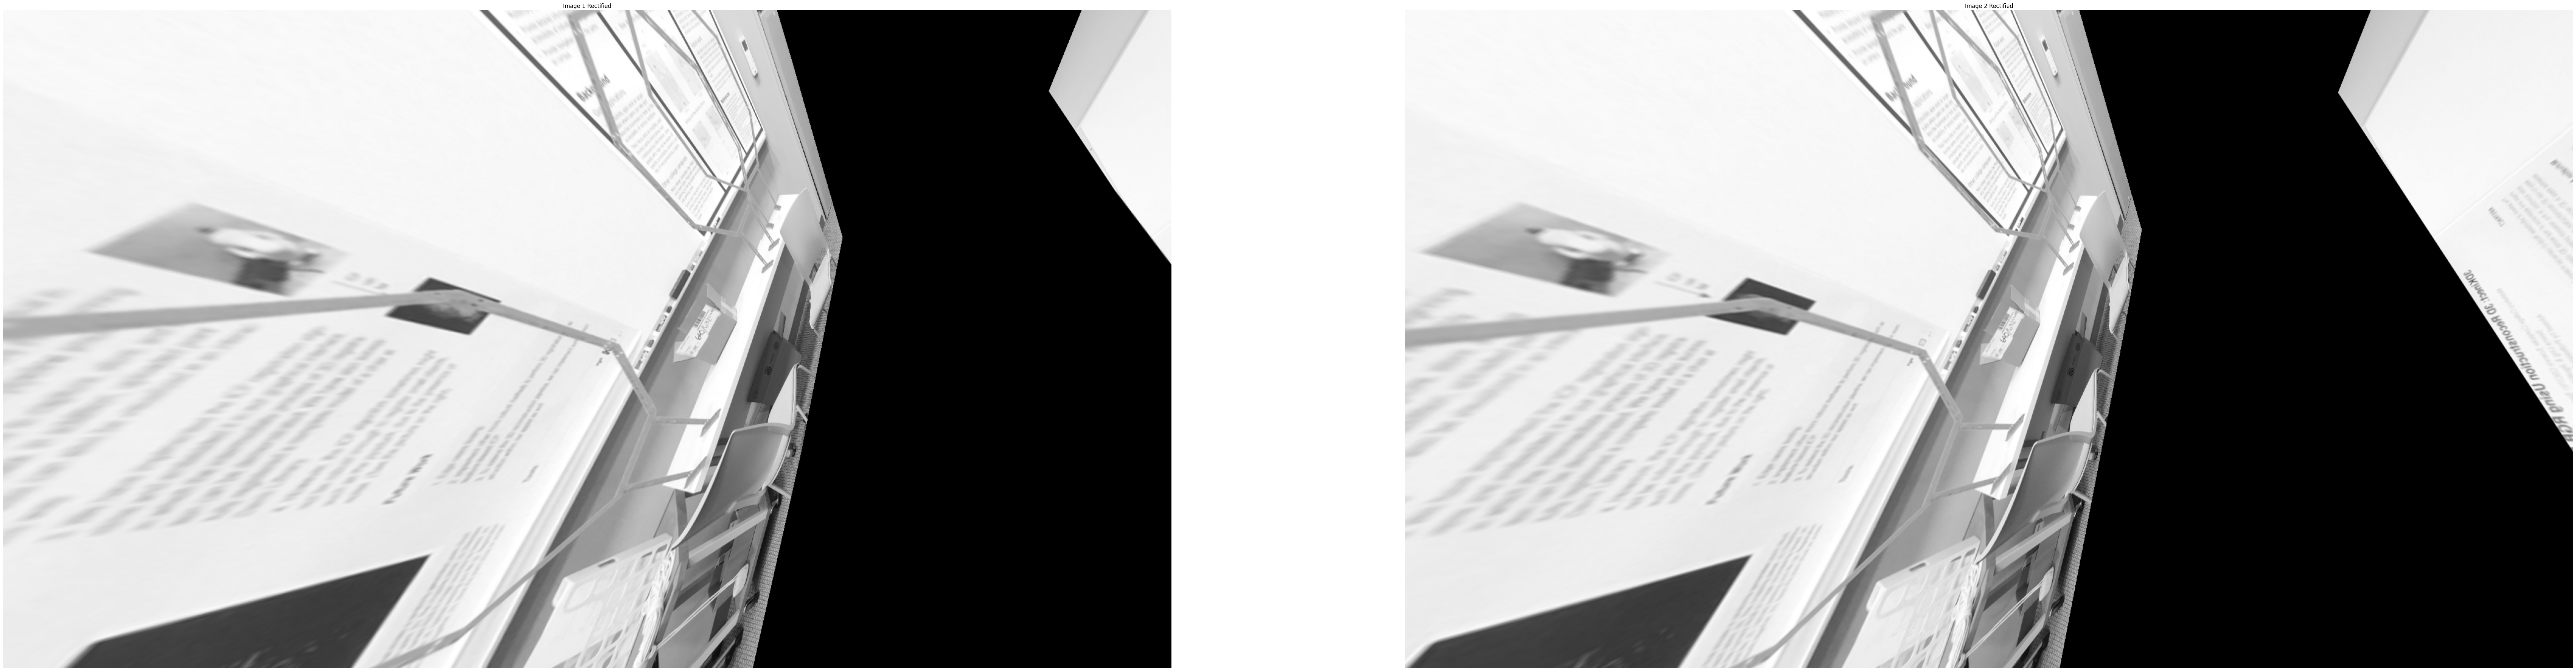

<ipython-input-12-9e3a1e286f12>:190: RuntimeWarning: divide by zero encountered in divide
  depthmap[i][j] = 1/img[i][j]
<ipython-input-12-9e3a1e286f12>:191: RuntimeWarning: divide by zero encountered in scalar divide
  deptharray[i][j] = baseline*f/img[i][j]


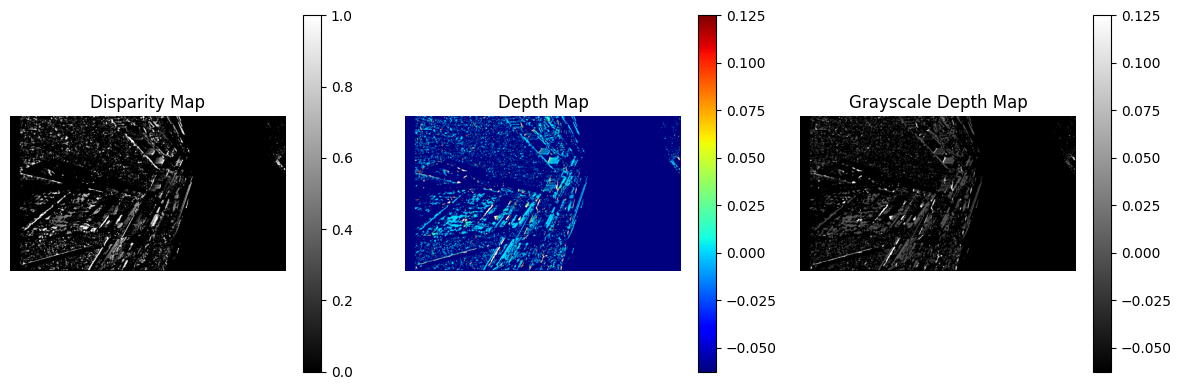

In [15]:
if __name__ == "__main__":
    storage_room()

# **Conclusion**
This notebook demonstrated stereo vision depth estimation using OpenCV and NumPy. We performed:
- **Feature Matching** (ORB, BFMatcher)
- **Fundamental & Essential Matrix Computation**
- **Stereo Rectification**
- **Disparity & Depth Mapping**

Depth estimation is widely used in robotics, autonomous driving, and 3D reconstruction.
